## Data Loading

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
np.random.seed(8) # for reproducibility
import matplotlib.pyplot as plt
import seaborn as sns

### train set, test set과 두 가지가 합쳐진 raw 파일 총 3가지 파일의 경로가 필요함

train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/df523_train.csv", encoding = 'utf-8')
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/df523_test.csv", encoding = 'utf-8')
raw = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/df523.csv", encoding = 'utf-8')

# train = train.drop(columns = 'Unnamed: 0')
train = train.rename(columns={'question__id' : 'question_id'})
# test = test.drop(columns = 'Unnamed: 0')
test = test.rename(columns={'question__id' : 'question_id'})
# raw = raw.drop(columns = 'Unnamed: 0')
raw = raw.rename(columns={'question__id' : 'question_id'})

# train set과 test set에서 같은 id들은 같은 정수로 바꿔줘야 제대로 embedding
print("Number of question_id : {} / Number of user_id : {}".format(len(train.question_id.unique()), len(train.user_id.unique())))
q_id = raw.question_id.unique()
u_id = raw.user_id.unique()

q_id_idx = {c: i for (i, c) in enumerate(q_id)}
u_id_idx = {c: i for (i, c) in enumerate(u_id)}
q = {c: i for (i, c) in enumerate(q_id)}
u = {c: i for (i, c) in enumerate(u_id)}

train.question_id = train.question_id.map(q)
train.user_id = train.user_id.map(u)
test.question_id = test.question_id.map(q)
test.user_id = test.user_id.map(u)

Number of question_id : 1836 / Number of user_id : 131028


In [0]:
print(train.isna().sum(), train.shape)
print(test.isna().sum(), test.shape)

user_id        0
question_id    0
result         0
dtype: int64 (4434076, 3)
user_id        0
question_id    0
result         0
dtype: int64 (189876, 3)


In [0]:
# 일정 문제 수 이상 푼 사람만 train set으로 두고 싶은 경우 추가적으로 실행 

l = train.user_id.value_counts() > 7
l = l[l].index
train = train[train.user_id.isin(l)]

논문에서의 문제 상황은 recommendation에 있어 implicit data를 활용하자는 것. implicit data는 user와 item의 일련의 contact에 관한 모든 정보를 포함하는 개념으로 꼭 'rating을 매겼다!'가 아니라 item을 클릭해보았다던가 하는 정보를 포괄한 개념으로 이는 item에 대해 user가 남긴 rating과 같은 explicit data의 개념보다 더 큰 개념.

## Modified version
ipynb 형태로 실행 + pandas dataframe 형태로 input 받기 위해 변경

In [0]:
from keras import initializers, metrics
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Flatten, concatenate, multiply
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from time import time
from sklearn.model_selection import train_test_split

class Dataset(object):

    def __init__(self, df):  # df 세분화 할 필요 있음

        self.num_users = len(df.user_id.unique())
        self.num_items = len(df.question_id.unique())

        self.uid = df.user_id.values
        self.qid = df.question_id.values
        self.result = df.result.values

Using TensorFlow backend.


#### GMF

In [0]:
## GMF를 위한 model을 build하는 부분

def get_model_GMF(num_users, num_items, latent_dim, regs=[0, 0]):
    
    ## user와 item input을 keras input 함수를 통해 집어넣는데 input 크기를 미리 고정시키지 않음
    ## shape=(1,100) 같은 형태로 고정시켜 버리면 무조건 해당 크기로 입력해야 해서 골치 아픔

    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')  # 알아서 one hot encoding처럼 되기에 int로 입력
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    ## keras의 Embedding() 함수를 이용해 user_id와 question_id의 latent vector을 얻기 위한 layer

    # MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', init = init_normal, W_regularizer = l2(regs[0]), input_length=1)
    MF_Embedding_User = Embedding(input_dim=num_users, output_dim=latent_dim,
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(regs[0]), input_length=1, name='user_embedding')
    # MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', init = init_normal, W_regularizer = l2(regs[1]), input_length=1)
    MF_Embedding_Item = Embedding(input_dim=num_items, output_dim=latent_dim,
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(regs[1]),
                                  input_length=1, name='item_embedding')
    

    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    ## user latent vector와 item latent vector를 elementwise product를 하기 위해 flatten 해줘야 함
    
    # Element-wise product of user and item embeddings 
    predict_vector = multiply([user_latent, item_latent])
    ## Element-wise product를 해줌

    # Final prediction layer
    prediction = Dense(1, activation='sigmoid',  # 처음에 나오는 숫자 1은 output dimension, 즉 user와 item 간의 implicit data 여부를 예측하는 확률
                       kernel_initializer=initializers.lecun_normal(), name='prediction')(predict_vector)
    ## 앞서 latent vector들을 element-wise product 한 것이 8차원이므로 마지막 layer는 8차원에서 1차원 값을 계산하는 fully connected layer가 됨.
    
    ## 위 과정은 각각 필요한 layer들을 한층한층 정의하는 과정. 아래의 Model() 함수를 통해 이들을 쌓아 하나의 모델을 생성
    model_ = Model(input=[user_input, item_input], output=prediction)

    return model_


def GMF_cal(regs=[0,0], lr=0.001, mf_dim=8):   #regs[a,b]: a는 user의 embedding시 이용, b는 item의 embedding시 이용

    ## 아래에는 학습에 필요한 parameter들
    learner = 'adam'    # optimizer 종류
    learning_rate = lr  # optimizer의 learning rate
    epochs = 3  # 전체 학습 iteration 수
    batch_size = 256    # 한번에 전체 데이터를 학습하지 않고 sampling하여 학습을 진행하는데 한 번 뽑는 data sample의 수
    verbose = 0     # 학습 진행률을 시각적으로 보여줄지 말지를 결정하는 변수
    val = 1     # 학습에서 validation set을 둘지 말지 여부 
    num_factors = mf_dim
    
    model_out_file = 'GMF_%d_%d.h5' % (num_factors, time())
    ## 학습된 모델을 .h5 확장자로 저장하는데 있어 파일명을 설정하는 부분
    
    # Loading data
    t1 = time()
    # xz
    trainset = Dataset(train) # 위에서 본 Dataset class 초기화 및 할당
    num_users, num_items = trainset.num_users, trainset.num_items
    print("Load data done [%.1f s]. #user=%d, #item=%d" 
          % (time()-t1, num_users, num_items))
    
    # mean_squared_error / binary_crossentropy
    model = get_model_GMF(num_users, num_items, num_factors, regs)
    if learner.lower() == "adagrad": 
        model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "rmsprop":
        model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "adam":
        model.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error', metrics=['acc'])
    else:
        model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])

    user_input, item_input, labels = trainset.uid, trainset.qid, trainset.result

    if val == 0:
        es = EarlyStopping(monitor='loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='acc', mode='max', verbose=verbose, save_best_only=True)

        hist = model.fit([np.array(user_input), np.array(item_input)],  # input
                     np.array(labels),  # labels
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc],
                     verbose=verbose, shuffle=True)
    else:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='val_acc', mode='max', verbose=verbose, save_best_only=True)
        
        user_input_train, user_input_val, item_input_train, item_input_val, labels_train, labels_val = train_test_split(
            user_input, item_input, labels, test_size = 0.05, random_state=8)
        
        hist = model.fit([np.array(user_input_train), np.array(item_input_train)],  # input
                     np.array(labels_train),  # labels
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc],
                     validation_data=([np.array(user_input_val), np.array(item_input_val)], np.array(labels_val)), 
                     verbose=verbose, shuffle=True)
    
    testset = Dataset(test)
    user_input_test, item_input_test, labels_test = testset.uid, testset.qid, testset.result

    print('# GMF evaluation on test data')
    results = model.evaluate([user_input_test, item_input_test], labels_test, batch_size = 256)
    prediction = model.predict([np.array(user_input_test), np.array(item_input_test)], batch_size=batch_size, verbose=1)
    global pred
    global test_label
    pred = prediction.flatten()
    test_label = labels_test
    print('test loss, test acc:', results)

    return results

print('GMF_cal(regs=[0,0], lr=0.001, mf_dim=8), GMF_cal 호출해주세요')


GMF_cal(regs=[0,0], lr=0.001, mf_dim=8), GMF_cal 호출해주세요


In [0]:
GMF_cal(regs=[0,0], lr=0.001, mf_dim=6)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# GMF evaluation on test data
262056/262056 [==============================] - 1s 6us/step
test loss, test acc: [0.1559631060875426, 0.7878430485725403]


[0.1559631060875426, 0.7878430485725403]

#### MLP

In [0]:
def MLP_cal(layers = [32,16,8,4], reg_layers=[0,0,0,0], lr=0.001):   #layer

    ## 아래에는 학습에 필요한 parameter들
    learner = 'adam'
    learning_rate = lr
    epochs = 3
    batch_size = 256
    verbose = 0
    val = 1

    model_out_file = 'MLP_%s_%d.h5' % (layers, time())

    # Loading data
    t1 = time()
    trainset = Dataset(train)
    num_users, num_items = trainset.num_users, trainset.num_items
    print("Load data done [%.1f s]. #user=%d, #item=%d" 
          % (time()-t1, num_users, num_items))
    
    ## 앞서 정의한 함수들을 통해 학습에 필요한 data들을 할당하고 완료될 경우 이를 출력하는 부분
    
    ## 어떤 optimizer를 사용할 지를 선택할 수 있도록 해놓은 부분
    # Build model
    model = get_model_MLP(num_users, num_items, layers, reg_layers)
    if learner.lower() == "adagrad":
        model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "rmsprop":
        model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "adam":
        model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    else:
        model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])


    user_input, item_input, labels = trainset.uid, trainset.qid, trainset.result
    
    if val == 0:
        es = EarlyStopping(monitor='loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='acc', mode='max', verbose=verbose, save_best_only=True)

        hist = model.fit([np.array(user_input), np.array(item_input)],  # input
                     np.array(labels),  # labels
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc],
                     verbose=verbose, shuffle=True)
    else:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='val_acc', mode='max', verbose=verbose, save_best_only=True)

        user_input_train, user_input_val, item_input_train, item_input_val, labels_train, labels_val = train_test_split(
            user_input, item_input, labels, test_size = 0.05, random_state=8)
        
        hist = model.fit([np.array(user_input_train), np.array(item_input_train)],  # input
                     np.array(labels_train),  # labels
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc],
                     validation_data=([np.array(user_input_val), np.array(item_input_val)], np.array(labels_val)), 
                     verbose=verbose, shuffle=True)
    
    testset = Dataset(test)
    user_input_test, item_input_test, labels_test = testset.uid, testset.qid, testset.result

    print('# MLP evaluation on test data')
    results = model.evaluate([user_input_test, item_input_test], labels_test, batch_size = 256)
    prediction = model.predict([np.array(user_input_test), np.array(item_input_test)], batch_size=batch_size, verbose=1)
    global pred
    global test_label
    pred = prediction.flatten()
    test_label = labels_test
    print('test loss, test acc:', results)

    return results


def get_model_MLP(num_users, num_items, layers=[20, 10], reg_layers=[0, 0]):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers)  # Number of layers in the MLP

    ## GMF 경우와 거의 동일. input과 latent vector를 얻기 위한 embedding 정의
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(input_dim=num_users, output_dim=int(layers[0]/2), name='user_embedding',
                                   embeddings_regularizer=l2(reg_layers[0]), input_length=1)
    MLP_Embedding_Item = Embedding(input_dim=num_items, output_dim=int(layers[0]/2), name='item_embedding',
                                   embeddings_regularizer=l2(reg_layers[0]), input_length=1)
    ## 위의 초기 설정 값에서 layer[0]은 64 였기에 각각 32차원의 latent vector를 만들어 embedding 후 concatenate를 아래에서 함
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    
    # The 0-th layer is the concatenation of embedding layers
    vector = concatenate([user_latent, item_latent])
    ## 다만 이 부분이 약간 다를 수 있는데 GMF 부분에서는 element-wise product를 하였지만
    ## MLP 부분에서는 두 latent vector의 interaction을 DNN 구조로 학습시키기 위해 concatenate를 해줌

    ## 아래는 MLP layer를 쌓는 부분으로 GMF와 같이 각각의 layer들을 정의해주고 마지막에 Model 함수를 통해 한 번에 쌓아줌
    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer=l2(reg_layers[idx]), activation='relu', name='layer%d' % idx)
        vector = layer(vector)          ## 중간 layer에서 acivation 함수로 Relu를 사용
    ## for문을 통해 이전 단계에서 쌓은 layer가 다음 단계 layer의 input으로 설정되고 있음
    ## 위 초기 설정에서 len(layers) = 4 이기에 hidden layer는 4층이 쌓임    

    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer=initializers.lecun_normal(),
                       name='prediction')(vector)
    
    model_ = Model(inputs=[user_input, item_input],
                   outputs=prediction)
    
    return model_


print('MLP_cal(layers = [32,16,8,4], reg_layers=[0,0,0,0], lr=0.001), MLP_cal 호출해주세요')

MLP_cal(layers = [32,16,8,4], reg_layers=[0,0,0,0], lr=0.001), MLP_cal 호출해주세요


In [0]:
MLP_cal(layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)

Load data done [0.1 s]. #user=94938, #item=1835


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# MLP evaluation on test data
189876/189876 [==============================] - 1s 6us/step
test loss, test acc: [0.451555282979982, 0.8036718964576721]


[0.451555282979982, 0.8036718964576721]

#### NeuMF

In [0]:
def get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers)  # Number of layers in the MLP
    # Input variables

    ## GMF와 MLP에서 만들었던 모델들을 한번에 쌓는 과정. 자세히 살펴보면 두 부분의 코드가 모두 들어가있음을 확인 가능
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    MF_Embedding_User = Embedding(input_dim=num_users, output_dim=mf_dim, name='mf_embedding_user',
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(reg_mf),
                                  input_length=1)
    MF_Embedding_Item = Embedding(input_dim=num_items, output_dim=mf_dim, name='mf_embedding_item',
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(reg_mf), input_length=1)

    MLP_Embedding_User = Embedding(input_dim=num_users, output_dim=int(layers[0] / 2), name="mlp_embedding_user",
                                   embeddings_initializer=initializers.random_normal(),
                                   embeddings_regularizer=l2(reg_layers[0]), input_length=1)
    MLP_Embedding_Item = Embedding(input_dim=num_items, output_dim=int(layers[0] / 2), name='mlp_embedding_item',
                                   embeddings_initializer=initializers.random_normal(),
                                   embeddings_regularizer=l2(reg_layers[0]), input_length=1)

    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    # mf_vector = merge([mf_user_latent, mf_item_latent], mode = 'mul') # element-wise multiply
    mf_vector = multiply([mf_user_latent, mf_item_latent])

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    # mlp_vector = merge([mlp_user_latent, mlp_item_latent], mode = 'concat')
    mlp_vector = concatenate([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer=l2(reg_layers[idx]), activation='relu', name="layer%d" % idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = concatenate([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer=initializers.lecun_normal(),
                       name="prediction")(predict_vector)

    model_ = Model(inputs=[user_input, item_input],
                   outputs=prediction)

    return model_


def NeuMF_cal(mf_dim=16, reg_mf = 0, layers = [64,32,16,8], reg_layers=[0,0,0,0], lr=0.001):

    ## 학습에 필요한 parameter들인데 살펴보면 위 부분에서 썼던 것들이 다 들어가있음
    num_epochs = 3
    batch_size = 256
    learning_rate = lr
    learner='adam'
    verbose = 0
    mf_pretrain = ''  ## 'Specify the pretrain model file for GMF part. If empty, no pretrain will be used'
    mlp_pretrain = ''  ## 'Specify the pretrain model file for MLP part. If empty, no pretrain will be used'
    val = 1

    model_out_file = 'NCF_%d_%s_%d.h5' % (mf_dim, layers, time())

    # Loading data
    t1 = time()
    trainset = Dataset(train)
    num_users, num_items = trainset.num_users, trainset.num_items
    print("Load data done [%.1f s]. #user=%d, #item=%d" 
          % (time()-t1, num_users, num_items))
    
    # Build model
    model = get_model(num_users, num_items, mf_dim, layers, reg_layers, reg_mf)
    if learner.lower() == "adagrad":
        model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "rmsprop":
        model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "adam":
        model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    else:
        model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])

    ## pretrain 된 weight를 불러오는 부분
    # Load pretrain model
    if mf_pretrain != '' and mlp_pretrain != '':
        gmf_model = get_model_GMF(num_users, num_items, mf_dim)
        gmf_model.load_weights(mf_pretrain)
        mlp_model = get_model_MLP(num_users, num_items, layers, reg_layers)
        mlp_model.load_weights(mlp_pretrain)
        model = load_pretrain_model(model, gmf_model, mlp_model, len(layers))
        print("Load pretrained GMF (%s) and MLP (%s) models done. " % (mf_pretrain, mlp_pretrain))

    # Training model
    
    user_input, item_input, labels = trainset.uid, trainset.qid, trainset.result

    if val == 0:
        es = EarlyStopping(monitor='loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='acc', mode='max', verbose=verbose, save_best_only=True)

        hist = model.fit([np.array(user_input), np.array(item_input)],  # input
                     np.array(labels),  # labels
                     batch_size=batch_size, epochs=num_epochs, callbacks=[es, mc],
                     verbose=verbose, shuffle=True)
    else:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='val_acc', mode='max', verbose=verbose, save_best_only=True)

        user_input_train, user_input_val, item_input_train, item_input_val, labels_train, labels_val = train_test_split(
            user_input, item_input, labels, test_size = 0.05, random_state=8)
        
        hist = model.fit([np.array(user_input_train), np.array(item_input_train)],  # input
                     np.array(labels_train),  # labels
                     batch_size=batch_size, epochs=num_epochs, callbacks=[es, mc],
                     validation_data=([np.array(user_input_val), np.array(item_input_val)], np.array(labels_val)), 
                     verbose=verbose, shuffle=True)
        
    testset = Dataset(test)
    user_input_test, item_input_test, labels_test = testset.uid, testset.qid, testset.result
    
    print('# NCF evaluation on test data')
    results = model.evaluate([user_input_test, item_input_test], labels_test, batch_size = 256)
    prediction = model.predict([np.array(user_input_test), np.array(item_input_test)], batch_size=batch_size, verbose=1)
    global pred
    global test_label
    pred = prediction.flatten()
    test_label = labels_test
    print('test loss, test acc:', results)

    return results


print('NeuMF_cal(mf_dim=16, reg_mf = 0, layers = [64,32,16,8], reg_layers=[0,0,0,0], lr=0.001), NeuMF_cal 호출해주세요')


NeuMF_cal(mf_dim=16, reg_mf = 0, layers = [64,32,16,8], reg_layers=[0,0,0,0], lr=0.001), NeuMF_cal 호출해주세요


In [0]:
NeuMF_cal(mf_dim=16, reg_mf = 0, layers = [64,32,16,8], reg_layers=[0,0,0,0], lr=0.001)

Load data done [0.1 s]. #user=94938, #item=1835


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# NCF evaluation on test data
189876/189876 [==============================] - 1s 7us/step
test loss, test acc: [0.5119858160638511, 0.778113067150116]


[0.5119858160638511, 0.778113067150116]

#### Threshold Change

In [0]:
alpha = 0.38

def fil(s):
  if s<alpha: return 0
  else: return 1

df_check = pd.DataFrame(data={'true':test_label, 'pred_raw': pred})

df_check['pred'] = df_check['pred_raw'].map(fil)
df_check['error'] = df_check['true'] - df_check['pred']

t = len(df_check)
e1 = len(df_check[df_check['error']==1]) / t  #실제 틀렸으나 맞았을 것으로 예측
e2 = len(df_check[df_check['error']==-1]) / t  #실제 맞았으나 틀렸을 것으로 예측
p1 = len(df_check[df_check['pred']==1]) / t
p2 = len(df_check[df_check['pred']==-0]) / t
pt1 = len(df_check[df_check['true']==1]) / t
pt2 = len(df_check[df_check['true']==0]) / t

print('실제 정답인 문제 / 틀린 문제 비율 : {:.5f} / {:.5f}'.format(pt2, pt1))
print('예측한 정답인 문제 / 틀린 문제 비율 : {:.5f} / {:.5f}'.format(p2, p1))
print('False positive rate(실제 틀렸으나 맞았을 것으로 예측) : {:.5f}'.format(e1))
print('False negative rate(실제 맞았으나 틀렸을 것으로 예측) : {:.5f}'.format(e2))
print('accuracy rate : {:.5f}'.format(1-(e1+e2)))

실제 정답인 문제 / 틀린 문제 비율 : 0.35992 / 0.64008
예측한 정답인 문제 / 틀린 문제 비율 : 0.26415 / 0.73585
False positive rate(실제 틀렸으나 맞았을 것으로 예측) : 0.05956
False negative rate(실제 맞았으나 틀렸을 것으로 예측) : 0.15533
accuracy rate : 0.78511


## Hyperparameter Tuning

In [0]:
#GMF : GMF_cal(regs=[0,0], lr=0.001, mf_dim=8)
#MLP : MLP_cal(layers = [32,16,8,4], reg_layers=[0,0,0,0], lr=0.001)
#NeuMF : NeuMF_cal(mf_dim=16, reg_mf = 0, layers = [64,32,16,8], reg_layers=[0,0,0,0], lr=0.001)

#### GMF latent vector dimension Tuning

In [0]:
def GMF_latent_tuning(min_dim = 4, max_dim = 6, lr = 0.001):
    acc=[]

    for i in range(min_dim,max_dim+1):
        print("Varify GMF GMF-Dimension to %d" %i)
        result = GMF_cal([0,0], lr, i)       
        acc.append(result[1])

    hyperGMF=pd.DataFrame(acc,columns=['acc'])
    hyperGMF['dim'] = range(min_dim, max_dim+1)
    hyperGMF.index=hyperGMF.dim
    hyperGMF=hyperGMF.drop('dim',1)
    hyperGMF.head(max_dim - min_dim+1)

    hyperGMF.acc.plot()
    plt.title('lr = {},  dim= {} to {}'.format(lr, min_dim, max_dim))

    return  hyperGMF


In [0]:
hyperGMF = GMF_latent_tuning(min_dim = 4, max_dim = 4, lr = 0.001)

Varify GMF GMF-Dimension to 4
Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


KeyboardInterrupt: ignored

Varify GMF GMF-Dimension to 20
Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# GMF evaluation on test data
262056/262056 [==============================] - 1s 4us/step
test loss, test acc: [0.16787160237793972, 0.7689768671989441]
Varify GMF GMF-Dimension to 21
Load data done [0.1 s]. #user=131028, #item=1836
# GMF evaluation on test data
262056/262056 [==============================] - 1s 3us/step
test loss, test acc: [0.17316130061631355, 0.7566397786140442]
Varify GMF GMF-Dimension to 22
Load data done [0.0 s]. #user=131028, #item=1836
# GMF evaluation on test data
262056/262056 [==============================] - 1s 3us/step
test loss, test acc: [0.17153223516600297, 0.7605168223381042]
Varify GMF GMF-Dimension to 23
Load data done [0.1 s]. #user=131028, #item=1836
# GMF evaluation on test data
262056/262056 [==============================] - 1s 3us/step
test loss, test acc: [0.16864415007905909, 0.7664468884468079]
Varify GMF GMF-Dimension to 24
Load data done [0.0 s]. #user=131028, #item=1836
# GMF evaluation on test data
262056/262056 [===================

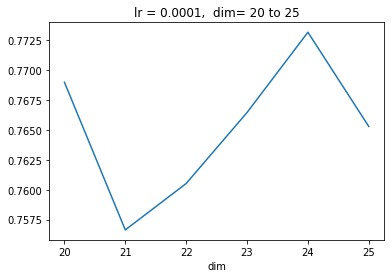

In [0]:
hyperGMF1 = GMF_latent_tuning(min_dim = 20, max_dim = 25, lr = 0.0001)

#### MLP layer dimension Tuning

In [0]:
def layer_cal(dim, num):
    a = [dim]
    for i in range(1,num):
        a.append(dim*(2**i))
    a.reverse()
    return a

def MLP_layer_tuning(max_layer_num, min_layer_num, end_layer = [4, 8], lr = 0.001):
    acc = []
    l = []
    for dim in end_layer:
        for num in range(min_layer_num, max_layer_num+1):
            print("[MLP] Last layer Dimension : {} / # of layers : {}".format(dim, num))
            result = MLP_cal(layers = layer_cal(dim, num), reg_layers = [0]*num, lr = lr)
            acc.append(result[1])
            l.append(layer_cal(dim, num))

    hyperMLP=pd.DataFrame(acc,columns=['acc'])
    hyperMLP['dim'] = l
    hyperMLP.index=hyperMLP.dim
    hyperMLP=hyperMLP.drop('dim',1)
    hyperMLP.head(len(end_layer)*(max_layer_num - min_layer_num +1))

    hyperMLP.acc.plot()

    return  hyperMLP


[MLP] Last layer Dimension : 4 / # of layers : 3
Load data done [0.1 s]. #user=94938, #item=1835


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# MLP evaluation on test data
189876/189876 [==============================] - 1s 6us/step
test loss, test acc: [0.45057465551390163, 0.8031768202781677]
[MLP] Last layer Dimension : 4 / # of layers : 4
Load data done [0.1 s]. #user=94938, #item=1835
# MLP evaluation on test data
189876/189876 [==============================] - 1s 6us/step
test loss, test acc: [0.45372093398258256, 0.8018496036529541]


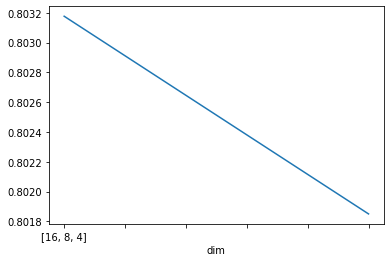

In [0]:
hyperMLP = MLP_layer_tuning(max_layer_num = 4, min_layer_num = 3, end_layer = [4], lr = 0.001)

#### NCF layer Tuning

In [0]:
def layer_cal(dim, num):
    a = [dim]
    for i in range(1,num):
        a.append(dim*(2**i))
    a.reverse()
    return a

def NCF_layer_tuning(max_layer_num, min_layer_num, end_layer = [4, 8], min_dim = 4, max_dim = 8, lr=0.001):
    acc = []
    l = []

    for i in range(min_dim,max_dim+1):
        for dim in end_layer:
            for num in range(min_layer_num, max_layer_num+1):
                print("[GMF] GMF latent Dimension {} / [MLP] Last layer Dimension : {} & # of layers : {}".format(i, dim, num))
                result = NeuMF_cal(mf_dim = i, reg_mf = 0, layers = layer_cal(dim, num), reg_layers=[0]*num, lr = lr)
                acc.append(result[1])
                l.append([i, layer_cal(dim, num)])

    hyperNCF=pd.DataFrame(acc,columns=['acc'])
    hyperNCF['dim'] = l
    hyperNCF.index=hyperNCF.dim
    hyperNCF=hyperNCF.drop('dim',1)
    hyperNCF.head(len(end_layer)*(max_layer_num - min_layer_num +1))

    hyperNCF.acc.plot()

    return  hyperNCF


[GMF] GMF latent Dimension 4 / [MLP] Last layer Dimension : 4 & # of layers : 3
Load data done [0.1 s]. #user=94938, #item=1835


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# NCF evaluation on test data
189876/189876 [==============================] - 1s 7us/step
test loss, test acc: [0.4612590608104284, 0.7990952134132385]
[GMF] GMF latent Dimension 4 / [MLP] Last layer Dimension : 4 & # of layers : 4
Load data done [0.1 s]. #user=94938, #item=1835
# NCF evaluation on test data
189876/189876 [==============================] - 1s 7us/step
test loss, test acc: [0.4602791180406035, 0.7987475991249084]
[GMF] GMF latent Dimension 4 / [MLP] Last layer Dimension : 4 & # of layers : 5
Load data done [0.0 s]. #user=94938, #item=1835
# NCF evaluation on test data
189876/189876 [==============================] - 1s 7us/step
test loss, test acc: [0.4651281092649524, 0.7958298921585083]
[GMF] GMF latent Dimension 4 / [MLP] Last layer Dimension : 8 & # of layers : 3
Load data done [0.1 s]. #user=94938, #item=1835
# NCF evaluation on test data
189876/189876 [==============================] - 1s 7us/step
test loss, test acc: [0.4639399470753374, 0.7969095706939697]
[GMF

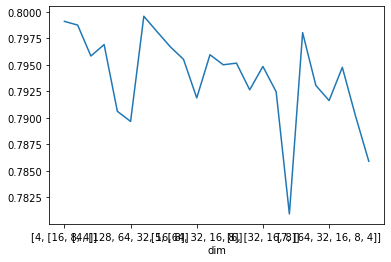

In [0]:
hyperNCF = NCF_layer_tuning(max_layer_num = 5, min_layer_num = 3, end_layer = [4, 8], min_dim = 4, max_dim = 7, lr=0.001)

In [0]:
hyperNCF

,acc
dim,
"[4, [16, 8, 4]]",0.799095
"[4, [32, 16, 8, 4]]",0.798748
"[4, [64, 32, 16, 8, 4]]",0.795830
"[4, [32, 16, 8]]",0.796910
"[4, [64, 32, 16, 8]]",0.790616
"[4, [128, 64, 32, 16, 8]]",0.789657
"[5, [16, 8, 4]]",0.799580
"[5, [32, 16, 8, 4]]",0.798126
"[5, [64, 32, 16, 8, 4]]",0.796699


## Candidate List

In [0]:
import os
import copy

### NCF_model 폴더의 weight 폴더안에 있는 파일 다운 받아서 경로 설정해주면 됩니다! ###

ncfpath = "/content/drive/My Drive/project/NCF_5_[16, 8, 4].h5"
mlppath = "/content/drive/My Drive/project/MLP_[16, 8, 4].h5"
gmfpath = "/content/drive/My Drive/project/GMF_6.h5"

q_meta = pd.read_csv("/content/drive/My Drive/project/gh_M3S1_question_meta.csv", encoding = 'utf-8')
trainset = Dataset(train)
num_users, num_items = trainset.num_users, trainset.num_items

def load_NeuMF(mf_dim=16, reg_mf = 0, layers = [64,32,16,8], reg_layers=[0,0,0,0], lr=0.001):
    if os.path.isfile(ncfpath):
        model = get_model(num_users, num_items, mf_dim, layers, reg_layers, reg_mf)
        model.load_weights(ncfpath)
        model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
        # metric을 RMSE로 혹은 loss를 RMSE로...?
        print("NeuMF Model loading completed from {}".format(ncfpath))
    
    return model

def load_MLP(layers = [32,16,8,4], reg_layers=[0,0,0,0], lr=0.001):
    if os.path.isfile(mlppath):
        model = get_model_MLP(num_users, num_items, layers, reg_layers)
        model.load_weights(mlppath)
        model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
        print("MLP Model loading completed from {}".format(mlppath))
    
    return model

def load_GMF(regs=[0,0], lr=0.001, latent_dim=8):
    if os.path.isfile(gmfpath):
        model = get_model_GMF(num_users, num_items, latent_dim, regs=[0, 0])
        model.load_weights(gmfpath)
        model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
        print("GMF Model loading completed from {}".format(gmfpath))
    
    return model


#model = load_NeuMF(mf_dim=5, reg_mf = 0, layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
model = load_MLP(layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
#model = load_GMF(regs=[0,0], lr=0.001, latent_dim=6)

MLP Model loading completed from /content/drive/My Drive/project/MLP_[16, 8, 4].h5


In [0]:
def cand_for_user(id, chap_num, cand_num, include = 0):     # user가 이미 푼 문제는 제외할 필요성 : include 변수

    # Split by chapter & mapping using q & u
    temp3 = copy.deepcopy(q_meta)
    temp3.question__genres__qtid = temp3.question__genres__qtid.astype(str).str[5:7].astype(int)
    c = copy.deepcopy(temp3[temp3.question__genres__qtid == chap_num])
    c.question__id = c.question__id.map(q)
    c = c.dropna(subset = ['question__id'])
    c.question__id = c.question__id.astype(int)

    c["user_id"] = u[id]
    inv_q = {v: k for k, v in q.items()}
    # inv_u = {v: k for k, v in u.items()}
    user_id = c.user_id.values
    chap = c.question__id.values
    prediction = model.predict([np.array(user_id), np.array(chap)], batch_size=1, verbose=1)

    result = copy.deepcopy(c)
    result['pred'] = prediction.reshape(-1)
    result = result[['question__id', 'pred', "question__text", "question__difficulty"]]
    candidate = result.question__id.values

    if include == 0:
        old = raw[raw.user_id == id].question_id.values
        candidate = np.setdiff1d(candidate, old)

    result = result[result.question__id.isin(candidate)]
    plt.figure(figsize = (8,4))
    sns.distplot(result.pred)
    result = result.sort_values(by = 'pred', ascending=False)
    result.question__id = result.question__id.map(inv_q)

    print("{} candidate questions for user_id = {}".format(cand_num, id))

    return result.head(cand_num)

# cand_for_user(id = 151253, chap_num = 1, cand_num = 10, include = 1)
# cand_for_user(id = 151253, chap_num = 1, cand_num = 10, include = 0)
# raw[raw.user_id == 151253]

118/118 [==============================] - 2s 15ms/step
15 candidate questions for user_id = 154723


,question__id,pred,question__text,question__difficulty
149,61,0.984795,"`100` 이하의 자연수 `n`에 대하여, `sqrt(3n)`가 무리수가 되도록 하는 `n`의 개수를 구하여라.",4
417,5172,0.982423,"자연수 `m`,`n`에 대하여 `m=sqrt(99/n)`일 때, `m+n`의 최댓값은?",5
1571,30267,0.935956,`sqrt(288/n`이 `1`보다 큰 자연수가 되도록 하는 자연수 `n`의 최댓값을 구하시오.,4
42,46,0.930710,`sqrt(135x)`가 자연수가 되도록 하는 `x`의 값 중에서 두 자리 자연수를 모두 구하면?<br/>(정답 `2`개),4
8,10,0.916926,위 식을 만족하는 `x`에 대하여 `30x`의 값을 구하시오.,5
53,60,0.904477,`sqrt(140-8n)`이 자연수가 되도록 하는 자연수 `n`의 값들의 합은?,3
45,50,0.899673,`sqrt(336/x)`의 값이 자연수가 되게 하는 두 자리 자연수 `x`의 값을 모두 더하면?,4
64,75,0.888773,"`-2 < sqrt(2x-1) < sqrt14`를 만족하는 자연수 `x`의 값 중에서 가장 큰 값을 `M`, 가장 작은 값을 `m`이라고 할 때, `M-m`의 값은?",4
36,38,0.885964,"`a > 0`, `bc > 0`, `ab < 0`일 때, `sqrt((-a)^2)-sqrt((b-a)^2)-sqrt((b+c)^2`을 간단히 한 것은?",4
48,54,0.879962,"두 실수 `sqrt(270/x)`, `sqrt(60-y)`가 자연수가 되도록 하는 가장 작은 자연수 `x`, `y`에 대하여 `x-y`의 값은?",4


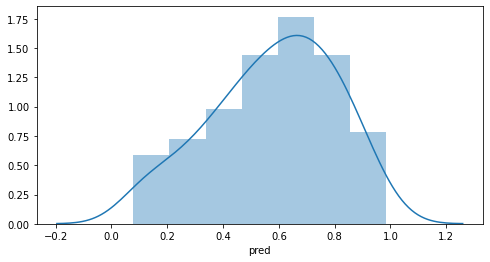

In [0]:
pd.set_option('max_colwidth', 100)
cand_for_user(id = 154723, chap_num = 1, cand_num = 15, include = 1)   # 151253, 154723, 155091

In [0]:
raw[raw.user_id == 155091]

,user_id,question_id,result
45051,155091,240,0
45052,155091,242,0
45053,155091,243,0
45054,155091,244,0
45055,155091,245,0
45056,155091,249,0
45057,155091,252,0
45058,155091,259,0
45059,155091,261,1
45060,155091,264,0


## Latent vector analysis
User latent vector의 경우 GMF, MLP, NCF 모든 모델에서 PCA로 살펴볼 경우 정답률에 대한 경향성이 나타남

#### MLP

In [0]:
from sklearn.decomposition import PCA
trainset = Dataset(train)
user_input, item_input = trainset.uid, trainset.qid

# qid = 10
model = load_MLP(layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
q_latent_model = Model(inputs = model.input[1],outputs = model.get_layer('item_embedding').output)
# q_latent = q_latent_model.predict(np.array([q[qid]]))
# print(q_latent)

q_latent = q_latent_model.predict(np.array(np.unique(item_input)))
t = q_latent.reshape(len(q_latent), -1)
q_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    q_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(q_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
plt.figure(figsize = (8,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', data = df_pca)


In [0]:
# For all user

from sklearn.decomposition import PCA
trainset = Dataset(train)
user_input, item_input = trainset.uid, trainset.qid

model = load_MLP(layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
u_latent_model = Model(inputs = model.input[0],outputs = model.get_layer('user_embedding').output)
# u_latent = u_latent_model.predict(np.array([u[uid]]))

u_latent = u_latent_model.predict(np.array(np.unique(user_input)))
t = u_latent.reshape(len(u_latent), -1)
u_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    u_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(u_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
plt.figure(figsize = (8,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', data = df_pca)

MLP Model loading completed from /content/drive/My Drive/project/MLP_[16, 8, 4].h5


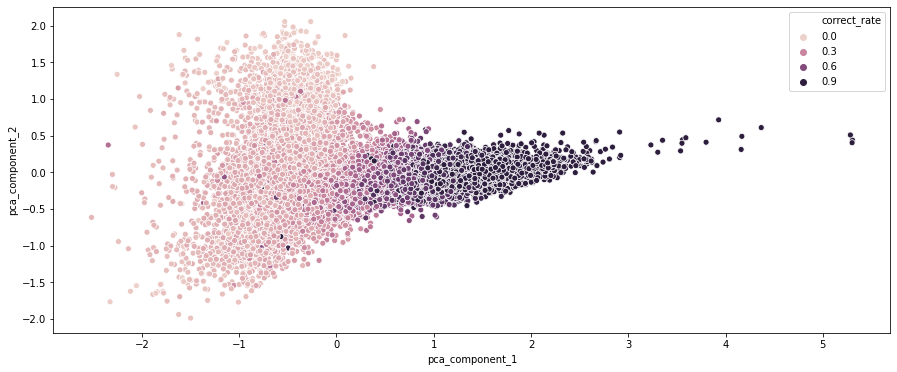

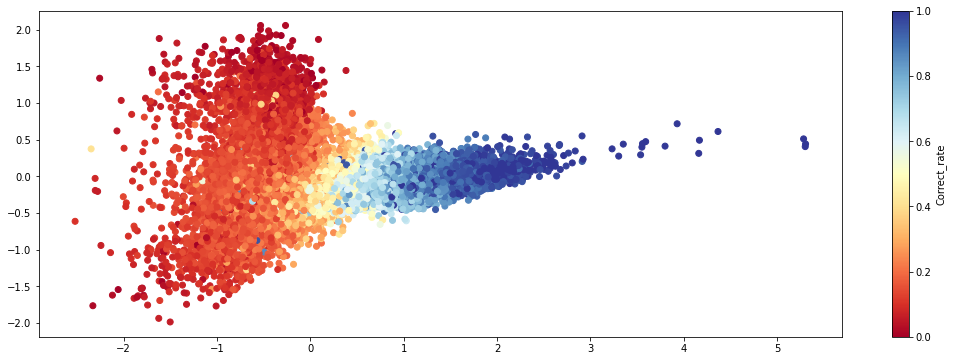

In [0]:
# For selected user with correct rate

from sklearn.decomposition import PCA
target_user = pd.read_csv("/content/drive/My Drive/project/user_cor.csv", encoding = 'utf-8')
target_user.user_id = target_user.user_id.map(u)

model = load_MLP(layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
u_latent_model = Model(inputs = model.input[0],outputs = model.get_layer('user_embedding').output)
user_input = target_user.user_id.values
# u_latent = u_latent_model.predict(np.array([u[uid]]))

u_latent = u_latent_model.predict(np.array(user_input))
t = u_latent.reshape(len(u_latent), -1)
u_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    u_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(u_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
df_pca['correct_rate'] = target_user.correct_per.values
plt.figure(figsize = (15,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', hue = 'correct_rate', hue_norm = (0, 0.9), data = df_pca)
plt.figure(figsize = (18,6))
plt.plot()
plt.scatter(df_pca.pca_component_1, df_pca.pca_component_2, c = df_pca.correct_rate, alpha = 1, cmap = plt.cm.get_cmap('RdYlBu'))
plt.colorbar(label='Correct_rate')

### GMF

In [0]:
from sklearn.decomposition import PCA
trainset = Dataset(train)
user_input, item_input = trainset.uid, trainset.qid

# qid = 10
model = load_GMF(regs=[0,0], lr=0.001, latent_dim=6)
q_latent_model = Model(inputs = model.input[1],outputs = model.get_layer('item_embedding').output)
# q_latent = q_latent_model.predict(np.array([q[qid]]))
# print(q_latent)

q_latent = q_latent_model.predict(np.array(np.unique(item_input)))
t = q_latent.reshape(len(q_latent), -1)
q_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    q_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(q_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
plt.figure(figsize = (8,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', data = df_pca)


In [0]:
# For all user

from sklearn.decomposition import PCA
trainset = Dataset(train)
user_input, item_input = trainset.uid, trainset.qid

model = load_GMF(regs=[0,0], lr=0.001, latent_dim=6)
u_latent_model = Model(inputs = model.input[0],outputs = model.get_layer('user_embedding').output)
# u_latent = u_latent_model.predict(np.array([u[uid]]))

u_latent = u_latent_model.predict(np.array(np.unique(user_input)))
t = u_latent.reshape(len(u_latent), -1)
u_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    u_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(u_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
plt.figure(figsize = (8,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', data = df_pca)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


GMF Model loading completed from /content/drive/My Drive/project/GMF_6.h5


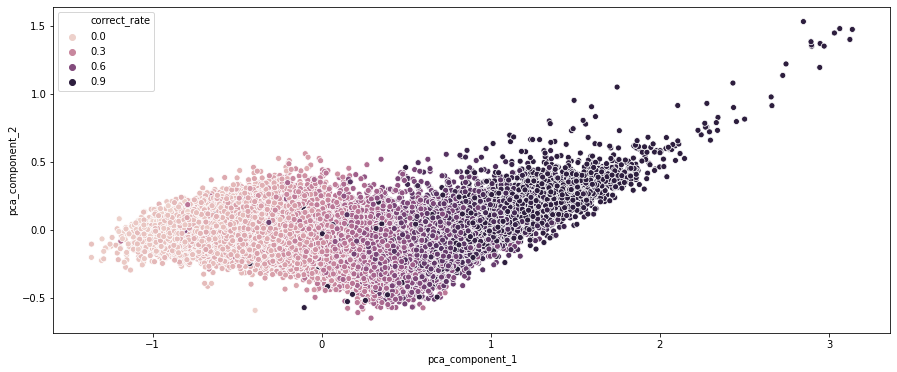

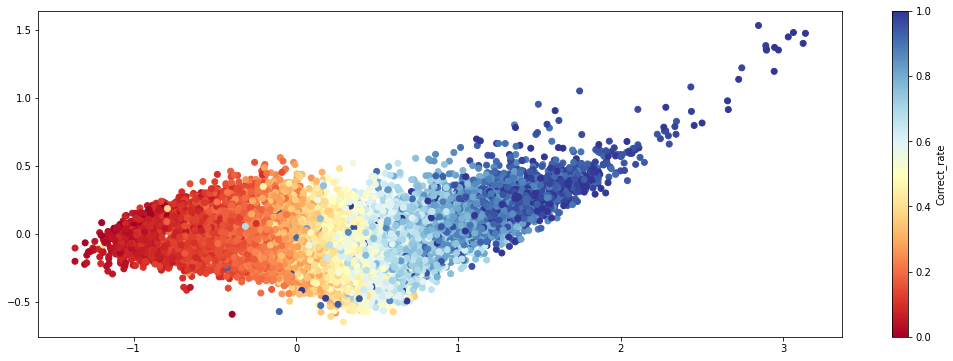

In [0]:
# For selected user with correct rate

from sklearn.decomposition import PCA
target_user = pd.read_csv("/content/drive/My Drive/project/user_cor.csv", encoding = 'utf-8')
target_user.user_id = target_user.user_id.map(u)

model = load_GMF(regs=[0,0], lr=0.001, latent_dim=6)
u_latent_model = Model(inputs = model.input[0],outputs = model.get_layer('user_embedding').output)
user_input = target_user.user_id.values
# u_latent = u_latent_model.predict(np.array([u[uid]]))

u_latent = u_latent_model.predict(np.array(user_input))
t = u_latent.reshape(len(u_latent), -1)
u_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    u_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(u_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
df_pca['correct_rate'] = target_user.correct_per.values
plt.figure(figsize = (15,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', hue = 'correct_rate', hue_norm = (0, 0.9), data = df_pca)
plt.figure(figsize = (18,6))
plt.plot()
plt.scatter(df_pca.pca_component_1, df_pca.pca_component_2, c = df_pca.correct_rate, alpha = 1, cmap = plt.cm.get_cmap('RdYlBu'))
plt.colorbar(label='Correct_rate')

### NCF

In [0]:
from sklearn.decomposition import PCA
trainset = Dataset(train)
user_input, item_input = trainset.uid, trainset.qid

# qid = 10
model = load_NeuMF(mf_dim=5, reg_mf = 0, layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
q_latent_model = Model(inputs = model.input[1],outputs = model.get_layer("mlp_embedding_item").output)
# q_latent = q_latent_model.predict(np.array([q[qid]]))
# print(q_latent)

q_latent = q_latent_model.predict(np.array(np.unique(item_input)))
t = q_latent.reshape(len(q_latent), -1)
q_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    q_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(q_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
plt.figure(figsize = (8,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', data = df_pca)


In [0]:
# For all user

from sklearn.decomposition import PCA
trainset = Dataset(train)
user_input, item_input = trainset.uid, trainset.qid

model = load_NeuMF(mf_dim=5, reg_mf = 0, layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
u_latent_model = Model(inputs = model.input[0],outputs = model.get_layer("mlp_embedding_user").output)
# u_latent = u_latent_model.predict(np.array([u[uid]]))

u_latent = u_latent_model.predict(np.array(np.unique(user_input)))
t = u_latent.reshape(len(u_latent), -1)
u_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    u_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(u_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
plt.figure(figsize = (8,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', data = df_pca)

NeuMF Model loading completed from /content/drive/My Drive/project/NCF_5_[16, 8, 4].h5


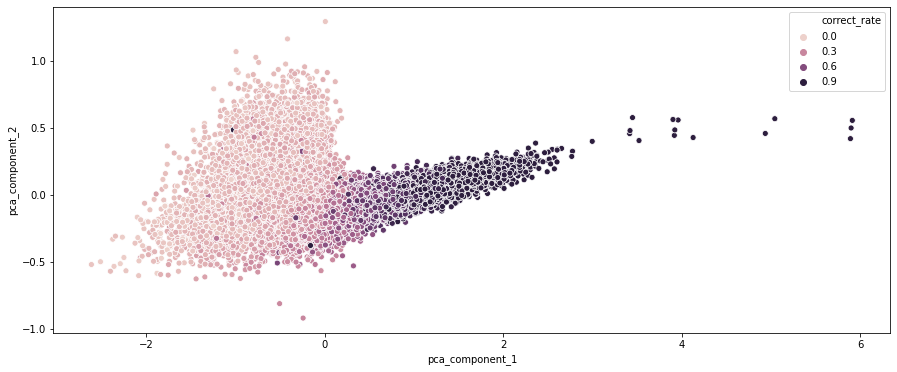

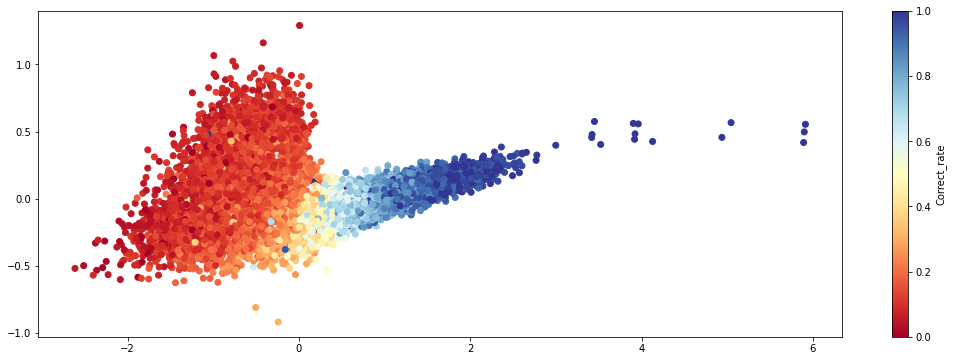

In [0]:
# For selected user with correct rate

from sklearn.decomposition import PCA
target_user = pd.read_csv("/content/drive/My Drive/project/user_cor.csv", encoding = 'utf-8')
target_user.user_id = target_user.user_id.map(u)

model = load_NeuMF(mf_dim=5, reg_mf = 0, layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
u_latent_model = Model(inputs = model.input[0],outputs = model.get_layer("mlp_embedding_user").output)
user_input = target_user.user_id.values
# u_latent = u_latent_model.predict(np.array([u[uid]]))

u_latent = u_latent_model.predict(np.array(user_input))
t = u_latent.reshape(len(u_latent), -1)
u_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    u_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(u_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
df_pca['correct_rate'] = target_user.correct_per.values
plt.figure(figsize = (15,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', hue = 'correct_rate', hue_norm = (0, 0.9), data = df_pca)
plt.figure(figsize = (18,6))
plt.plot()
plt.scatter(df_pca.pca_component_1, df_pca.pca_component_2, c = df_pca.correct_rate, alpha = 1, cmap = plt.cm.get_cmap('RdYlBu'))
plt.colorbar(label='Correct_rate')

NeuMF Model loading completed from /content/drive/My Drive/project/NCF_5_[16, 8, 4].h5


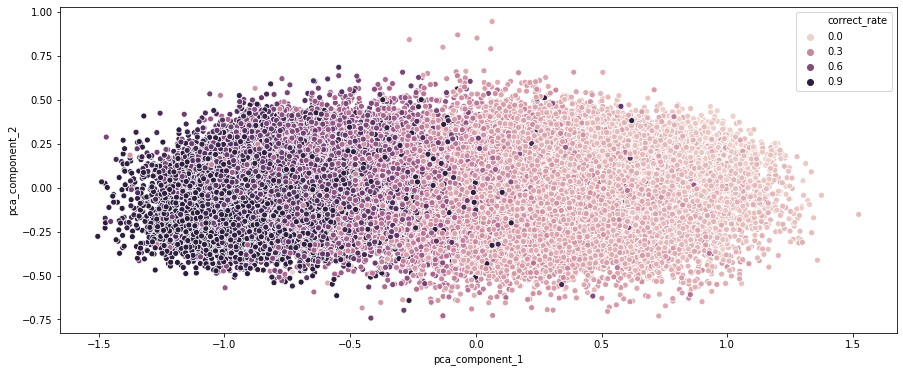

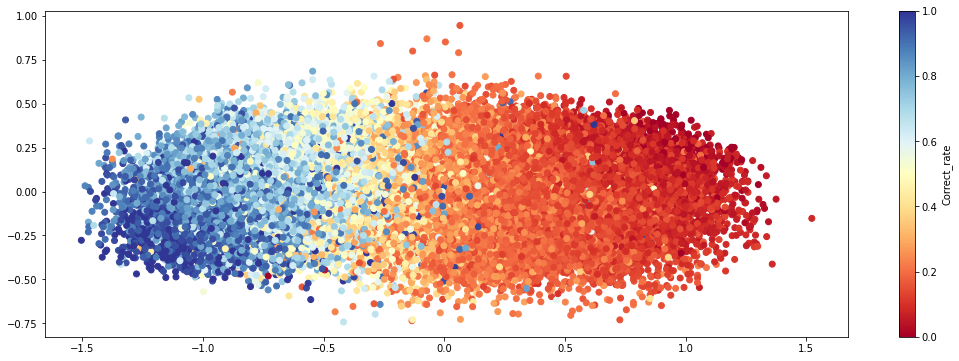

In [0]:
# For selected user with correct rate

from sklearn.decomposition import PCA
target_user = pd.read_csv("/content/drive/My Drive/project/user_cor.csv", encoding = 'utf-8')
target_user.user_id = target_user.user_id.map(u)

model = load_NeuMF(mf_dim=5, reg_mf = 0, layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)
u_latent_model = Model(inputs = model.input[0],outputs = model.get_layer('mf_embedding_user').output)
user_input = target_user.user_id.values
# u_latent = u_latent_model.predict(np.array([u[uid]]))

u_latent = u_latent_model.predict(np.array(user_input))
t = u_latent.reshape(len(u_latent), -1)
u_tbl = pd.DataFrame(data = {'0' : t[:,0]})
for i in range(1, t.shape[1]):
    u_tbl[str(i)] = t[:,i]

x_pca = PCA(n_components=2).fit_transform(u_tbl)
df_pca = pd.DataFrame(x_pca,columns = ['pca_component_1','pca_component_2'])
df_pca['correct_rate'] = target_user.correct_per.values
plt.figure(figsize = (15,6))
sns.scatterplot(x = 'pca_component_1', y = 'pca_component_2', hue = 'correct_rate', hue_norm = (0, 0.9), data = df_pca)
plt.figure(figsize = (18,6))
plt.plot()
plt.scatter(df_pca.pca_component_1, df_pca.pca_component_2, c = df_pca.correct_rate, alpha = 1, cmap = plt.cm.get_cmap('RdYlBu'))
plt.colorbar(label='Correct_rate')

## Baseline model

틀린 경우에 대한 Precision : 0.79086 / 틀린 경우에 대한 Recall : 0.80069 / F1 score : 0.79574
맞은 경우에 대한 Precision : 0.69105 / 맞은 경우에 대한 Recall : 0.67799 / F1 score : 0.68446
accuracy rate : 0.75201


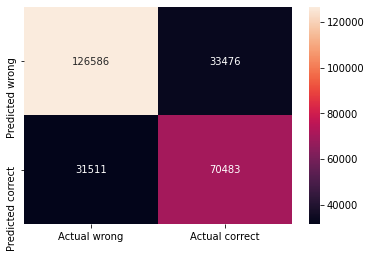

In [0]:
# 10문제 이상 푼 학생들에 대한 예측

threshold = 0.5

tbl = pd.DataFrame({'user_id' : train.user_id.unique()})
tbl['wrong_rate'] = train.groupby(train.user_id).sum().result / train.groupby(train.user_id).count().result
tbl = dict([(i,j) for i, j in zip(tbl.user_id, tbl.wrong_rate)])

def pred(user_id):
    if tbl[user_id] > threshold: return 1
    else:   return 0

test['pred'] = test['user_id'].map(pred)

TP = len(test[(test['pred'] == 1) & (test['result'] == 1)])
FN = len(test[(test['pred'] == 0) & (test['result'] == 1)])
FP = len(test[(test['pred'] == 1) & (test['result'] == 0)])
TN = len(test[(test['pred'] == 0) & (test['result'] == 0)])

print("틀린 경우에 대한 Precision : {:.5f} / 틀린 경우에 대한 Recall : {:.5f} / F1 score : {:.5f}".format(TP/(TP+FP), 
        TP/(TP+FN), 2*(TP/(TP+FP)*TP/(TP+FN)/(TP/(TP+FP) + TP/(TP+FN)))))
print("맞은 경우에 대한 Precision : {:.5f} / 맞은 경우에 대한 Recall : {:.5f} / F1 score : {:.5f}".format(TN/(TN+FN), 
        TN/(TN+FP), 2*(TN/(TN+FN)*TN/(TN+FP)/(TN/(TN+FN) + TN/(TN+FP)))))

heat = np.array([[TP,FP],[FN,TN]])
sns.heatmap(heat, annot=True, fmt="d", xticklabels=['Actual wrong', 'Actual correct'], yticklabels=['Predicted wrong', 'Predicted correct'])
print('accuracy rate : {:.5f}'.format((TP + TN)/(TP + TN + FN + FP)))

## total

In [0]:
import pandas as pd
import numpy as np
np.random.seed(8) # for reproducibility
import matplotlib.pyplot as plt
import seaborn as sns

### train set, test set과 두 가지가 합쳐진 raw 파일 총 3가지 파일의 경로가 필요함

train = pd.read_csv("/content/drive/My Drive/GROWTH HACKERS/GH_Mathpresso/DATA/df523_train.csv", encoding = 'utf-8')
test = pd.read_csv("/content/drive/My Drive/GROWTH HACKERS/GH_Mathpresso/DATA/df523_test_killer.csv", encoding = 'utf-8')
raw = pd.read_csv("/content/drive/My Drive/GROWTH HACKERS/GH_Mathpresso/DATA/df523.csv", encoding = 'utf-8')

#train = train.drop(columns = 'Unnamed: 0')
train = train.rename(columns={'question__id' : 'question_id'})
#test = test.drop(columns = 'Unnamed: 0')
test = test.rename(columns={'question__id' : 'question_id'})
# raw = raw.drop(columns = 'Unnamed: 0')
raw = raw.rename(columns={'question__id' : 'question_id'})

# train set과 test set에서 같은 id들은 같은 정수로 바꿔줘야 제대로 embedding
print("Number of question_id : {} / Number of user_id : {}".format(len(train.question_id.unique()), len(train.user_id.unique())))
q_id = raw.question_id.unique()
u_id = raw.user_id.unique()

q_id_idx = {c: i for (i, c) in enumerate(q_id)}
u_id_idx = {c: i for (i, c) in enumerate(u_id)}
q = {c: i for (i, c) in enumerate(q_id)}
u = {c: i for (i, c) in enumerate(u_id)}

train.question_id = train.question_id.map(q)
train.user_id = train.user_id.map(u)
test.question_id = test.question_id.map(q)
test.user_id = test.user_id.map(u)

######################################

from keras import initializers, metrics
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Flatten, concatenate, multiply
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from time import time
from sklearn.model_selection import train_test_split

class Dataset(object):

    def __init__(self, df):  # df 세분화 할 필요 있음

        self.num_users = len(df.user_id.unique())
        self.num_items = len(df.question_id.unique())

        self.uid = df.user_id.values
        self.qid = df.question_id.values
        self.result = df.result.values

######################################

def get_model_GMF(num_users, num_items, latent_dim, regs=[0, 0]):

    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')  # 알아서 one hot encoding처럼 되기에 int로 입력
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(input_dim=num_users, output_dim=latent_dim,
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(regs[0]), input_length=1, name='user_embedding')
    MF_Embedding_Item = Embedding(input_dim=num_items, output_dim=latent_dim,
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(regs[1]),
                                  input_length=1, name='item_embedding')
    
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    predict_vector = multiply([user_latent, item_latent])

    prediction = Dense(1, activation='sigmoid',  # 처음에 나오는 숫자 1은 output dimension, 즉 user와 item 간의 implicit data 여부를 예측하는 확률
                       kernel_initializer=initializers.lecun_normal(), name='prediction')(predict_vector)

    model_ = Model(input=[user_input, item_input], output=prediction)

    return model_


def GMF_cal(regs=[0,0], lr=0.001, mf_dim=8):   #regs[a,b]: a는 user의 embedding시 이용, b는 item의 embedding시 이용

    learner = 'adam'    # optimizer 종류
    learning_rate = lr  # optimizer의 learning rate
    epochs = 3  # 전체 학습 iteration 수
    batch_size = 256    # 한번에 전체 데이터를 학습하지 않고 sampling하여 학습을 진행하는데 한 번 뽑는 data sample의 수
    verbose = 0     # 학습 진행률을 시각적으로 보여줄지 말지를 결정하는 변수
    val = 1     # 학습에서 validation set을 둘지 말지 여부 
    num_factors = mf_dim
    
    model_out_file = 'GMF_%d_%d.h5' % (num_factors, time())

    t1 = time()
    # xz
    trainset = Dataset(train) # 위에서 본 Dataset class 초기화 및 할당
    num_users, num_items = trainset.num_users, trainset.num_items
    print("Load data done [%.1f s]. #user=%d, #item=%d" 
          % (time()-t1, num_users, num_items))
    
    # mean_squared_error / binary_crossentropy
    model = get_model_GMF(num_users, num_items, num_factors, regs)
    if learner.lower() == "adagrad": 
        model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "rmsprop":
        model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "adam":
        model.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error', metrics=['acc'])
    else:
        model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])

    user_input, item_input, labels = trainset.uid, trainset.qid, trainset.result

    if val == 0:
        es = EarlyStopping(monitor='loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='acc', mode='max', verbose=verbose, save_best_only=True)

        hist = model.fit([np.array(user_input), np.array(item_input)],  # input
                     np.array(labels),  # labels
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc],
                     verbose=verbose, shuffle=True)
    else:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='val_acc', mode='max', verbose=verbose, save_best_only=True)
        
        user_input_train, user_input_val, item_input_train, item_input_val, labels_train, labels_val = train_test_split(
            user_input, item_input, labels, test_size = 0.05, random_state=8)
        
        hist = model.fit([np.array(user_input_train), np.array(item_input_train)],  # input
                     np.array(labels_train),  # labels
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc],
                     validation_data=([np.array(user_input_val), np.array(item_input_val)], np.array(labels_val)), 
                     verbose=verbose, shuffle=True)
    
    testset = Dataset(test)
    user_input_test, item_input_test, labels_test = testset.uid, testset.qid, testset.result

    print('# GMF evaluation on test data')
    results = model.evaluate([user_input_test, item_input_test], labels_test, batch_size = 256)
    prediction = model.predict([np.array(user_input_test), np.array(item_input_test)], batch_size=batch_size, verbose=1)
    global pred
    global test_label
    pred = prediction.flatten()
    test_label = labels_test
    print('test loss, test acc:', results)

    return results

######################################

def MLP_cal(layers = [32,16,8,4], reg_layers=[0,0,0,0], lr=0.001):   #layer

    learner = 'adam'
    learning_rate = lr
    epochs = 3
    batch_size = 256
    verbose = 0
    val = 1

    model_out_file = 'MLP_%s_%d.h5' % (layers, time())

    t1 = time()
    trainset = Dataset(train)
    num_users, num_items = trainset.num_users, trainset.num_items
    print("Load data done [%.1f s]. #user=%d, #item=%d" 
          % (time()-t1, num_users, num_items))
    

    model = get_model_MLP(num_users, num_items, layers, reg_layers)
    if learner.lower() == "adagrad":
        model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "rmsprop":
        model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "adam":
        model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    else:
        model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])


    user_input, item_input, labels = trainset.uid, trainset.qid, trainset.result
    
    if val == 0:
        es = EarlyStopping(monitor='loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='acc', mode='max', verbose=verbose, save_best_only=True)

        hist = model.fit([np.array(user_input), np.array(item_input)],  # input
                     np.array(labels),  # labels
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc],
                     verbose=verbose, shuffle=True)
    else:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='val_acc', mode='max', verbose=verbose, save_best_only=True)

        user_input_train, user_input_val, item_input_train, item_input_val, labels_train, labels_val = train_test_split(
            user_input, item_input, labels, test_size = 0.05, random_state=8)
        
        hist = model.fit([np.array(user_input_train), np.array(item_input_train)],  # input
                     np.array(labels_train),  # labels
                     batch_size=batch_size, epochs=epochs, callbacks=[es, mc],
                     validation_data=([np.array(user_input_val), np.array(item_input_val)], np.array(labels_val)), 
                     verbose=verbose, shuffle=True)
    
    testset = Dataset(test)
    user_input_test, item_input_test, labels_test = testset.uid, testset.qid, testset.result

    print('# MLP evaluation on test data')
    results = model.evaluate([user_input_test, item_input_test], labels_test, batch_size = 256)
    prediction = model.predict([np.array(user_input_test), np.array(item_input_test)], batch_size=batch_size, verbose=1)
    global pred
    global test_label
    pred = prediction.flatten()
    test_label = labels_test
    print('test loss, test acc:', results)

    return results


def get_model_MLP(num_users, num_items, layers=[20, 10], reg_layers=[0, 0]):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers)  # Number of layers in the MLP

    ## GMF 경우와 거의 동일. input과 latent vector를 얻기 위한 embedding 정의
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(input_dim=num_users, output_dim=int(layers[0]/2), name='user_embedding',
                                   embeddings_regularizer=l2(reg_layers[0]), input_length=1)
    MLP_Embedding_Item = Embedding(input_dim=num_items, output_dim=int(layers[0]/2), name='item_embedding',
                                   embeddings_regularizer=l2(reg_layers[0]), input_length=1)

    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    vector = concatenate([user_latent, item_latent])

    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer=l2(reg_layers[idx]), activation='relu', name='layer%d' % idx)
        vector = layer(vector)          ## 중간 layer에서 acivation 함수로 Relu를 사용
    prediction = Dense(1, activation='sigmoid', kernel_initializer=initializers.lecun_normal(),
                       name='prediction')(vector)
    
    model_ = Model(inputs=[user_input, item_input],
                   outputs=prediction)
    
    return model_

######################################

def get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers)  # Number of layers in the MLP
    # Input variables

    ## GMF와 MLP에서 만들었던 모델들을 한번에 쌓는 과정. 자세히 살펴보면 두 부분의 코드가 모두 들어가있음을 확인 가능
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    MF_Embedding_User = Embedding(input_dim=num_users, output_dim=mf_dim, name='mf_embedding_user',
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(reg_mf),
                                  input_length=1)
    MF_Embedding_Item = Embedding(input_dim=num_items, output_dim=mf_dim, name='mf_embedding_item',
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(reg_mf), input_length=1)

    MLP_Embedding_User = Embedding(input_dim=num_users, output_dim=int(layers[0] / 2), name="mlp_embedding_user",
                                   embeddings_initializer=initializers.random_normal(),
                                   embeddings_regularizer=l2(reg_layers[0]), input_length=1)
    MLP_Embedding_Item = Embedding(input_dim=num_items, output_dim=int(layers[0] / 2), name='mlp_embedding_item',
                                   embeddings_initializer=initializers.random_normal(),
                                   embeddings_regularizer=l2(reg_layers[0]), input_length=1)

    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    # mf_vector = merge([mf_user_latent, mf_item_latent], mode = 'mul') # element-wise multiply
    mf_vector = multiply([mf_user_latent, mf_item_latent])

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    # mlp_vector = merge([mlp_user_latent, mlp_item_latent], mode = 'concat')
    mlp_vector = concatenate([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer=l2(reg_layers[idx]), activation='relu', name="layer%d" % idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = concatenate([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer=initializers.lecun_normal(),
                       name="prediction")(predict_vector)

    model_ = Model(inputs=[user_input, item_input],
                   outputs=prediction)

    return model_


def NeuMF_cal(mf_dim=16, reg_mf = 0, layers = [64,32,16,8], reg_layers=[0,0,0,0], lr=0.001):

    ## 학습에 필요한 parameter들인데 살펴보면 위 부분에서 썼던 것들이 다 들어가있음
    num_epochs = 3
    batch_size = 256
    learning_rate = lr
    learner='adam'
    verbose = 0
    mf_pretrain = ''  ## 'Specify the pretrain model file for GMF part. If empty, no pretrain will be used'
    mlp_pretrain = ''  ## 'Specify the pretrain model file for MLP part. If empty, no pretrain will be used'
    val = 1

    model_out_file = 'NCF_%d_%s_%d.h5' % (mf_dim, layers, time())

    # Loading data
    t1 = time()
    trainset = Dataset(train)
    num_users, num_items = trainset.num_users, trainset.num_items
    print("Load data done [%.1f s]. #user=%d, #item=%d" 
          % (time()-t1, num_users, num_items))
    
    # Build model
    model = get_model(num_users, num_items, mf_dim, layers, reg_layers, reg_mf)
    if learner.lower() == "adagrad":
        model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "rmsprop":
        model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    elif learner.lower() == "adam":
        model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])
    else:
        model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])

    ## pretrain 된 weight를 불러오는 부분
    # Load pretrain model
    if mf_pretrain != '' and mlp_pretrain != '':
        gmf_model = get_model_GMF(num_users, num_items, mf_dim)
        gmf_model.load_weights(mf_pretrain)
        mlp_model = get_model_MLP(num_users, num_items, layers, reg_layers)
        mlp_model.load_weights(mlp_pretrain)
        model = load_pretrain_model(model, gmf_model, mlp_model, len(layers))
        print("Load pretrained GMF (%s) and MLP (%s) models done. " % (mf_pretrain, mlp_pretrain))

    # Training model
    
    user_input, item_input, labels = trainset.uid, trainset.qid, trainset.result

    if val == 0:
        es = EarlyStopping(monitor='loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='acc', mode='max', verbose=verbose, save_best_only=True)

        hist = model.fit([np.array(user_input), np.array(item_input)],  # input
                     np.array(labels),  # labels
                     batch_size=batch_size, epochs=num_epochs, callbacks=[es, mc],
                     verbose=verbose, shuffle=True)
    else:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=4)
        mc = ModelCheckpoint(model_out_file, monitor='val_acc', mode='max', verbose=verbose, save_best_only=True)

        user_input_train, user_input_val, item_input_train, item_input_val, labels_train, labels_val = train_test_split(
            user_input, item_input, labels, test_size = 0.05, random_state=8)
        
        hist = model.fit([np.array(user_input_train), np.array(item_input_train)],  # input
                     np.array(labels_train),  # labels
                     batch_size=batch_size, epochs=num_epochs, callbacks=[es, mc],
                     validation_data=([np.array(user_input_val), np.array(item_input_val)], np.array(labels_val)), 
                     verbose=verbose, shuffle=True)
        
    testset = Dataset(test)
    user_input_test, item_input_test, labels_test = testset.uid, testset.qid, testset.result
    
    print('# NCF evaluation on test data')
    results = model.evaluate([user_input_test, item_input_test], labels_test, batch_size = 256)
    prediction = model.predict([np.array(user_input_test), np.array(item_input_test)], batch_size=batch_size, verbose=1)
    global pred
    global test_label
    pred = prediction.flatten()
    test_label = labels_test
    print('test loss, test acc:', results)

    return results

Number of question_id : 1836 / Number of user_id : 131028


In [0]:
#easy
MLP_cal(layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# MLP evaluation on test data
98030/98030 [==============================] - 0s 4us/step
test loss, test acc: [0.44750217987750973, 0.8046618103981018]


[0.44750217987750973, 0.8046618103981018]

In [0]:
#medium
MLP_cal(layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# MLP evaluation on test data
74880/74880 [==============================] - 0s 4us/step
test loss, test acc: [0.5156094394178472, 0.7653312087059021]


[0.5156094394178472, 0.7653312087059021]

In [0]:
#killer
MLP_cal(layers = [16,8,4], reg_layers=[0,0,0], lr=0.001)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# MLP evaluation on test data
89146/89146 [==============================] - 0s 4us/step
test loss, test acc: [0.415635916369846, 0.8087295293807983]


[0.415635916369846, 0.8087295293807983]

In [0]:
#easy
GMF_cal(regs=[0,0], lr=0.001, mf_dim=4)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# GMF evaluation on test data
98030/98030 [==============================] - 0s 4us/step
test loss, test acc: [0.1488790792314347, 0.803590714931488]


[0.1488790792314347, 0.803590714931488]

In [0]:
#medium
GMF_cal(regs=[0,0], lr=0.001, mf_dim=4)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# GMF evaluation on test data
74880/74880 [==============================] - 0s 4us/step
test loss, test acc: [0.17151521049503587, 0.7643830180168152]


[0.17151521049503587, 0.7643830180168152]

In [0]:
#killer
GMF_cal(regs=[0,0], lr=0.001, mf_dim=4)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# GMF evaluation on test data
89146/89146 [==============================] - 0s 4us/step
test loss, test acc: [0.146190090613965, 0.799160897731781]


[0.146190090613965, 0.799160897731781]

In [0]:
#easy
NeuMF_cal(mf_dim=4, reg_mf = 0, layers = [32,16,8], reg_layers=[0,0,0], lr=0.001)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# NCF evaluation on test data
98030/98030 [==============================] - 0s 5us/step
test loss, test acc: [0.46068654303208767, 0.7989084720611572]


[0.46068654303208767, 0.7989084720611572]

In [0]:
#medium
NeuMF_cal(mf_dim=4, reg_mf = 0, layers = [32,16,8], reg_layers=[0,0,0], lr=0.001)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# NCF evaluation on test data
74880/74880 [==============================] - 0s 5us/step
test loss, test acc: [0.5364834588817042, 0.7570379376411438]


[0.5364834588817042, 0.7570379376411438]

In [0]:
#killer
NeuMF_cal(mf_dim=4, reg_mf = 0, layers = [32,16,8], reg_layers=[0,0,0], lr=0.001)

Load data done [0.1 s]. #user=131028, #item=1836


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# NCF evaluation on test data
89146/89146 [==============================] - 0s 5us/step
test loss, test acc: [0.4280182280496712, 0.8026495575904846]


[0.4280182280496712, 0.8026495575904846]

## Working

### Noise Robustness